# Correlation of halorun miscentering properties with triaxiality


In [273]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir, bigdata_home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/miscentering/'
buzzdir = home_dir() + 'output/buzzard/'
toolsdir = tools_home_dir()
homedir = home_dir()
bigdatadir = bigdata_home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

## Import catalogs

In [274]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn
import pickle

#filename = homedir +'output/buzzard/halo_shape/halo_shape_redM_matched_v1.2.npy'
#See if using a different filename changes things.
filename = homedir +'output/buzzard/redM_halos_fullmatchingparams_matchingv1.3_Buzzardv1.6.data'
infile = open(filename,'rb')
redM_shape = pickle.load(infile)
redM_shape = redM_shape.view(np.recarray)

print "Number of halos in the redM catalog is ", len(redM_shape)
print redM_shape.dtype

#Apply mass cut
print "Number of halos is ", len(redM_shape)

Number of halos in the redM catalog is  13628
(numpy.record, [('GALAXY_ID', '<i8'), ('HALOID', '<i8'), ('DESCID', '>i8'), ('RA_OBS', '>f8'), ('DEC_OBS', '>f8'), ('TRA', '>f8'), ('TDEC', '>f8'), ('Z', '>f8'), ('MVIR', '>f8'), ('VMAX', '>f8'), ('VRMS', '>f8'), ('RVIR', '>f8'), ('RS', '>f8'), ('NP', '>f8'), ('PX', '>f8'), ('PY', '>f8'), ('PZ', '>f8'), ('VX', '>f8'), ('VY', '>f8'), ('VZ', '>f8'), ('JX', '>f8'), ('JY', '>f8'), ('JZ', '>f8'), ('SPIN', '>f8'), ('RS_KLYPIN', '>f8'), ('MVIR_ALL', '>f8'), ('M200B', '>f8'), ('M200C', '>f8'), ('M500C', '>f8'), ('M2500C', '>f8'), ('XOFF', '>f8'), ('VOFF', '>f8'), ('SPIN_BULLOCK', '>f8'), ('B_TO_A', '>f8'), ('C_TO_A', '>f8'), ('PID', '>i8'), ('LUMTOT', '>f8'), ('LUM20', '>f8'), ('LBCG', '>f8'), ('NGALS', '>i8'), ('N18', '>i8'), ('N19', '>i8'), ('N20', '>i8'), ('N21', '>i8'), ('N22', '>i8'), ('matching_ID', '<i8'), ('MEM_MATCH_ID', '<i8'), ('LAMBDA_CHISQ', '<f8'), ('RA_REDM', '<f8'), ('DEC_REDM', '<f8'), ('q', '<f8'), ('s', '<f8'), ('cosi', '<f8'), (

### redMaPPer catalog


In [275]:
#Import the redMaPPer galaxy catalog
homedir = home_dir()
redM_dir = bigdatadir + '/Buzzard_Sims/v1.6/buzzard_halo/redM/'+'buzzard-0_1.6_y3_run_redmapper_v6.4.20_lgt20_vl02_catalog.fit'

redM_list = fits.open(redM_dir)
redM_data = redM_list[1].data
redM_data = redM_data.view(np.recarray)

print "Names of redM_matched halo column data are:"
print redM_data.dtype.names, "\n"
print "Number of redM read is ", len(redM_data)

#Matching to the redM_halos. MEM_MATCH_ID
matched_memID = np.intersect1d(redM_data['MEM_MATCH_ID'], redM_shape.MEM_MATCH_ID)
matched_ind = [i for (i,x) in enumerate(redM_data['MEM_MATCH_ID']) if x in matched_memID]
redM_data = redM_data[matched_ind] #filter by matched redM objects
print "Number of redM objects matched to redM_halos are ", len(redM_data)

Names of redM_matched halo column data are:
('MEM_MATCH_ID', 'RA', 'DEC', 'MODEL_MAG', 'MODEL_MAGERR', 'REFMAG', 'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED_CHISQ', 'BCG_SPEC_Z', 'Z_SPEC_INIT', 'Z_INIT', 'Z', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'R_LAMBDA', 'SCALEVAL', 'MASKFRAC', 'GEOMASKFRAC', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'CHISQ', 'Z_LAMBDA', 'Z_LAMBDA_E', 'Z_LAMBDA_NITER', 'EBV_MEAN', 'LNLAMLIKE', 'LNBCGLIKE', 'LNLIKE', 'PZBINS', 'PZ', 'NCROSS', 'RMASK', 'RA_ORIG', 'DEC_ORIG', 'W', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'LAMBDA_CHISQ_C', 'LAMBDA_CHISQ_CE', 'NCENT', 'NCENT_GOOD', 'RA_CENT', 'DEC_CENT', 'ID_CENT', 'LAMBDA_CHISQ_CENT', 'ZLAMBDA_CENT', 'P_BCG', 'P_CEN', 'Q_CEN', 'P_FG', 'Q_MISS', 'P_SAT', 'P_C', 'BCG_ILUM', 'ILUM', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD') 

Number of redM read is  24243
Number of redM objects matched to redM_halos are  13628


### redMaPPer member catalog

In [276]:
redM_dir = bigdatadir + 'Buzzard_Sims/v1.6/buzzard_halo/redM/buzzard-0_1.6_y3_run_redmapper_v6.4.20_lgt5_vl02_catalog_members.fit'
redM_list = fits.open(redM_dir)
redM_members = redM_list[1].data

#Checking FITS into
#hrun_list.info()
print "Names of columns in redM_data are: \n"
print redM_members.names

#Converting FITS files into record array
redM_members = redM_members.view(np.recarray)

print "\n Number of redMaPPer members is", len(redM_members.ID)

Names of columns in redM_data are: 

['MEM_MATCH_ID', 'Z', 'RA', 'DEC', 'R', 'P', 'PFREE', 'THETA_I', 'THETA_R', 'MODEL_MAG', 'MODEL_MAGERR', 'REFMAG_FIT', 'REFMAG_FIT_E', 'REFMAG', 'REFMAG_ERR', 'ZRED', 'ZRED_E', 'ZRED2', 'ZRED2_E', 'CHISQ', 'EBV', 'ZSPEC', 'ID']

 Number of redMaPPer members is 6418974


## Divide shape file into centered/miscentered

In [277]:
##Centered population
redM_shape_cent = redM_shape[np.where(redM_shape.centered_flag==1)]
redM_shape_miscent = redM_shape[np.where(redM_shape.centered_flag==0)]
print "Number of centered: ", len(redM_shape_cent)
print "Number of miscenterd: ", len(redM_shape_miscent)

Number of centered:  8541
Number of miscenterd:  5087


### Extracting info from centered

In [278]:
'''
##Shorthand name for relevant halo/redM parameters
print "Before convergence cut number of halos is ", len(redM_cent)
halos_ID_cent, q_cent, s_cent, cos_i_cent = read_shape_param(np.array(redM_shape_cent), convcut=True)
#Choose only convergent halos
conv_cut = [i for (i,x) in enumerate(redM_shape_cent.halos_ID) if x in halos_ID_cent]
redM_shape_cent = redM_shape_cent[conv_cut]
print "After convergence cut number of halos is ", len(redM_cent)
'''
q_cent = redM_shape_cent.q; s_cent = redM_shape_cent.s; cos_i_cent = redM_shape_cent.cosi
richness = redM_shape_cent.LAMBDA_CHISQ
halos_M  = redM_shape_cent.M200B

coord_cent = np.zeros( (len(redM_shape_cent),2))
coord_cent[:,0] = redM_shape_cent.RA_OBS; coord_cent[:,1] = redM_shape_cent.DEC_OBS

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Halo mass range is from  13.044735697450507 15.356618541969091


### Binning by cos(i) and \lambda

In [279]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind_cent = halo_bin_stat(cos_i_cent, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind_cent = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q_cent))]

Maximum richness after cuts is  303.0442810058594


In [280]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned_cent = [None]*num_bins
lnl_binned_cent = [None]*num_bins

lnl_cent = np.log(richness)
lnM200b_cent = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned_cent[i] = np.log(halos_M[cosi_bins_ind_cent[i]])
    lnl_binned_cent[i] = np.log(richness[cosi_bins_ind_cent[i]])

### Extracting info from miscentered

In [281]:
q_miscent = redM_shape_miscent.q; s_miscent = redM_shape_miscent.s; cos_i_miscent = redM_shape_miscent.cosi
richness = redM_shape_miscent.LAMBDA_CHISQ
halos_M  = redM_shape_miscent.M200B

coord_miscent = np.zeros( (len(redM_shape_miscent),2))
coord_miscent[:,0] = redM_shape_miscent.RA_OBS; coord_miscent[:,1] = redM_shape_miscent.DEC_OBS

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Halo mass range is from  13.000564216165376 15.53186194909581


In [282]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind_miscent = halo_bin_stat(cos_i_miscent, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind_miscent = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q_miscent))]

Maximum richness is  247.15005493164062


In [283]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned_miscent = [None]*num_bins
lnl_binned_miscent = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned_miscent[i] = np.log(halos_M[cosi_bins_ind_miscent[i]])
    lnl_binned_miscent[i] = np.log(richness[cosi_bins_ind_miscent[i]])

## $\Delta \lambda$ vs $\cos{(i)}$

### Importing hrun and matching

In [284]:
from tools.setup.setup import data_home_dir, home_dir
import astropy.io.fits as fits
datadir = data_home_dir()
homedir = home_dir()
hrun_dir = bigdatadir + 'Buzzard_Sims/v1.6/halo_run/'+'buzzard-0_1.6_y3_run_halos_lambda_chisq_chto_fullhalo_final_chto.fit'
hrun_list = fits.open(hrun_dir)
hrun_data = hrun_list[1].data

#Checking FITS into
#hrun_list.info()
print "Names of columns in hrun_data are: \n"
print hrun_data.names

#Converting FITS files into record array
hrun_data = np.array(hrun_data, dtype=hrun_data.dtype)
hrun_data = hrun_data.view(np.recarray)

print "\n Number of halos is", len(hrun_data)

Names of columns in hrun_data are: 

['HALOID', 'Mvir', 'R200', 'MEM_MATCH_ID', 'RA', 'DEC', 'Z', 'P_BCG', 'Z_LAMBDA', 'LAMBDA_CHISQ', 'LAMBDA_CHISQ_E', 'LAMBDA_CHISQ_ZORIG', 'SCALEVAL', 'LAMBDA_ZRED', 'LAMBDA_ZRED_E', 'MASKFRAC', 'GEOMASKFRAC', 'R_LAMBDA', 'R_MASK', 'Z_LAMBDA_E', 'NCROSS', 'Z_LAMBDA_NITER', 'DLAMBDA_DZ', 'DLAMBDA_DZ2', 'DLAMBDAVAR_DZ', 'DLAMBDAVAR_DZ2', 'C_LAMBDA', 'C_LAMBDA_ERR', 'MAG_LAMBDA_ERR', 'PZBINS', 'PZ', 'Z_LAMBDA_RAW', 'Z_LAMBDA_E_RAW', 'BCG_SPEC_Z', 'LIM_EXPTIME', 'LIM_LIMMAG_DERED', 'LIM_LIMMAG', 'LIM_LIMMAG_HARD', 'ra_cent', 'dec_cent', 'p_cen', 'p_sat', 'ID_CENT', 'M200B']

 Number of halos is 144508


### Hrun filter

In [285]:
#Halo_Run catalog has repeating halos. Clean that up
unique_ID, unique_ind = np.unique(hrun_data.HALOID, return_index=True)
hrun_data = hrun_data[unique_ind]

print "Before richness cut number of halos in hrun_data  is ", len(hrun_data)
#Apply richness cut to hrun
hruncut = np.where(hrun_data.LAMBDA_CHISQ >= 20)
hrun_data = hrun_data[hruncut]
print "After richness cut number of halos in hrun_data  is ", len(hrun_data)

#Match hrun to other catalogs
print "Before halocut but after mass cut number of halos in hrun_data is ", len(hrun_data)
hrun_bool = np.isin(hrun_data.HALOID, redM_shape.HALOID)
hruncut = np.where(hrun_bool == True)[0]
hrun_data = hrun_data[hruncut]
print "After halocut number of halos in hrun_data is ", len(hrun_data)

#Match shape catalog to hrun
print "Before halocut but after mass cut number of halos in redM_shape is ", len(redM_shape)
hrun_bool = np.isin(redM_shape.HALOID, hrun_data.HALOID)
hruncut = np.where(hrun_bool == True)[0]
redM_shape = redM_shape[hruncut]
print "After halocut number of halos in redM_shape is ", len(redM_shape)

Before richness cut number of halos in hrun_data  is  144508
After richness cut number of halos in hrun_data  is  60955
Before halocut but after mass cut number of halos in hrun_data is  60955
After halocut number of halos in hrun_data is  12023
Before halocut but after mass cut number of halos in redM_shape is  13628
After halocut number of halos in redM_shape is  12023


### Sorting by ID

In [286]:
#Sort the arrays by order of ID. That way the indices match. 

#For hrun
ID_sort = np.argsort(hrun_data.HALOID)
hrun_data = hrun_data[ID_sort]
print "After sorting, IDs in hrun are: "
print hrun_data.HALOID, "\n"

#For shape
ID_sort = np.argsort(redM_shape.HALOID)
redM_shape = redM_shape[ID_sort]
print "After sorting, IDs in redM_shape are: "
print redM_shape.HALOID, "\n"

After sorting, IDs in hrun are: 
[  2184825   2203138   2240565 ... 139807773 139808405 139860811] 

After sorting, IDs in redM_shape are: 
[  2184825   2203138   2240565 ... 139807773 139808405 139860811] 



## Divide into center and miscenter

In [287]:
cent_ind = np.where(redM_shape['centered_flag'] == 1)
miscent_ind = np.where(redM_shape['centered_flag'] == 0)

#Split into centered and miscentered
hrun_cent = hrun_data[cent_ind]
hrun_miscent = hrun_data[miscent_ind]
redM_shape_cent = redM_shape[cent_ind]
redM_shape_miscent = redM_shape[miscent_ind]

#Making into recarrays
hrun_cent = hrun_cent.view(np.recarray)
hrun_miscent = hrun_miscent.view(np.recarray)
redM_shape_cent = redM_shape_cent.view(np.recarray)
redM_shape_miscent = redM_shape_miscent.view(np.recarray)

print "Number of centered after hrun matching: ", len(hrun_cent), len(redM_shape_cent)
print "Number of miscentered after hrun matching: ", len(hrun_miscent), len(redM_shape_miscent)

Number of centered after hrun matching:  7872 7872
Number of miscentered after hrun matching:  4151 4151


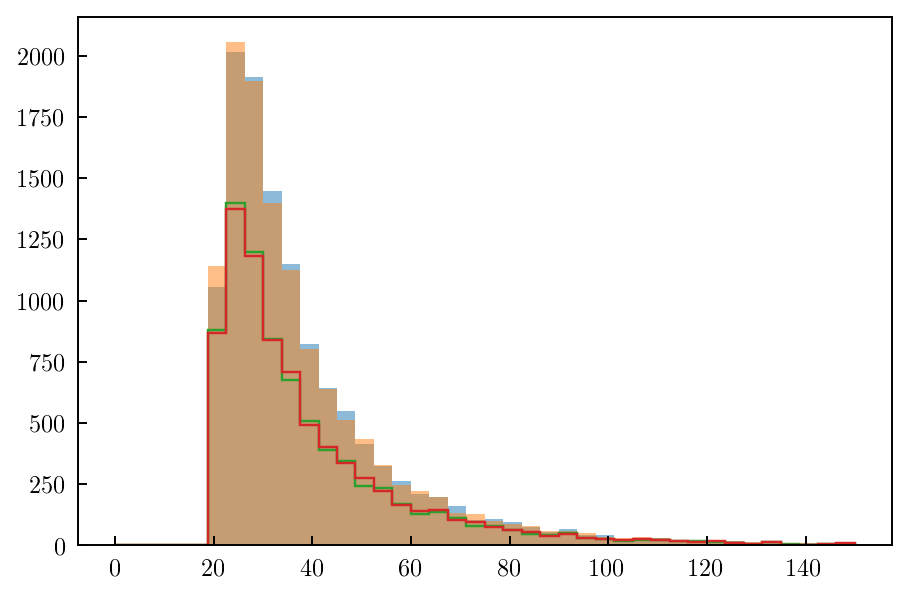

In [288]:
## Testing
num_bins = 40
hist_range = (0,150)
plt.hist(hrun_data.LAMBDA_CHISQ, num_bins, alpha=0.5, range=hist_range)
plt.hist(redM_shape.LAMBDA_CHISQ, num_bins, alpha=0.5, range=hist_range)
plt.hist(hrun_cent.LAMBDA_CHISQ, num_bins, fill=False, range=hist_range, histtype='step')
plt.hist(redM_shape_cent.LAMBDA_CHISQ, num_bins, fill=False, range=hist_range, histtype='step')
plt.show()

### Miscentered Distance
For miscentered clusters only

In [299]:
from astropy import units as u
from astropy import cosmology
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

#Z using the true redshift
halos_matched_d = cosmo.comoving_distance(redM_shape.Z)
halos_matched_d_miscent = cosmo.comoving_distance(redM_shape_miscent.Z)

#redM 3D coord
redM_coord = SkyCoord(redM_shape.RA_REDM*u.deg, redM_shape.DEC_REDM*u.deg, distance=halos_matched_d, frame='icrs')
redM_coord_miscent = SkyCoord(redM_shape_miscent.RA_REDM*u.deg, redM_shape_miscent.DEC_REDM*u.deg, distance=halos_matched_d_miscent, frame='icrs')

#halorun 3D coord
halos_matched_coord = SkyCoord(hrun_data.RA*u.deg, hrun_data.DEC*u.deg, distance=halos_matched_d, frame='icrs')
halos_matched_coord_miscent = SkyCoord(hrun_miscent.RA*u.deg, hrun_miscent.DEC*u.deg, distance=halos_matched_d_miscent, frame='icrs')

#Miscentered distance between the two
rsep_miscent = halos_matched_coord_miscent.separation_3d(redM_coord_miscent).value
rsep_all = halos_matched_coord.separation_3d(redM_coord).value

In [300]:
#Convert 3D distance to R_lambda units
h=0.7
#Define r_lambda
r_lambda = (redM_shape.LAMBDA_CHISQ/100)**(0.2)/h
r_lambda_miscent = (redM_shape_miscent.LAMBDA_CHISQ/100)**(0.2)/h

#Take ratio of r_sep and r_lambda
r_ratio = rsep_all/r_lambda
r_ratio_miscent = rsep_miscent/r_lambda_miscent

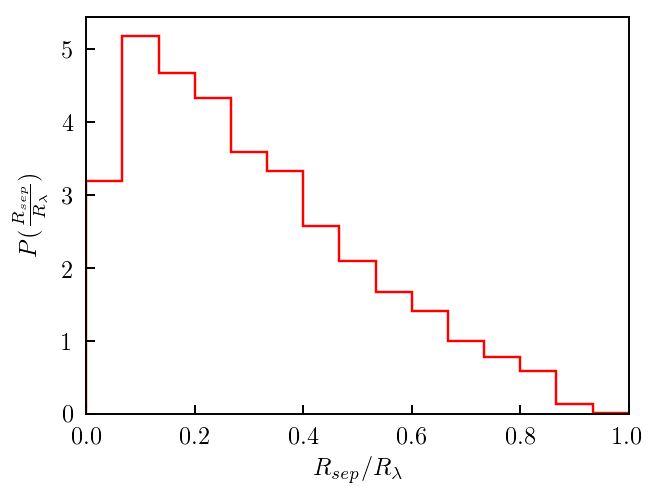

In [301]:
fig, axs = plt.subplots(1, figsize=(4,3))
num_bin=15;
hist_range = (0,1)

weights = np.ones_like(r_ratio_miscent, dtype=float)/len(r_ratio)* 100

#Plotting random halos
axs.hist(r_ratio_miscent, num_bin, range=hist_range, color='red', density=False, weights=weights, histtype='step', fill=False)
#axs[1].hist(miscenter_d_hrun/R_lambda, num_bin, range=hist_range, label='red-matched halos in hrun')

#Plot config   
#axs[0].set_ylim((0,6000))
axs.set_xlabel(r'$R_{sep}/R_\lambda$')
axs.set_ylabel(r'$P(\frac{R_{sep}}{R_\lambda})$')
#axs[0].set_title(r'Ellipticity: Minor to major axis ratio', fontsize=10)
#axs.legend(loc='best', fontsize=10, frameon=False)
#axs.set_ylim((0,150))
axs.set_xlim((0,1))
plt.show()

### Miscentering bias with separation distance

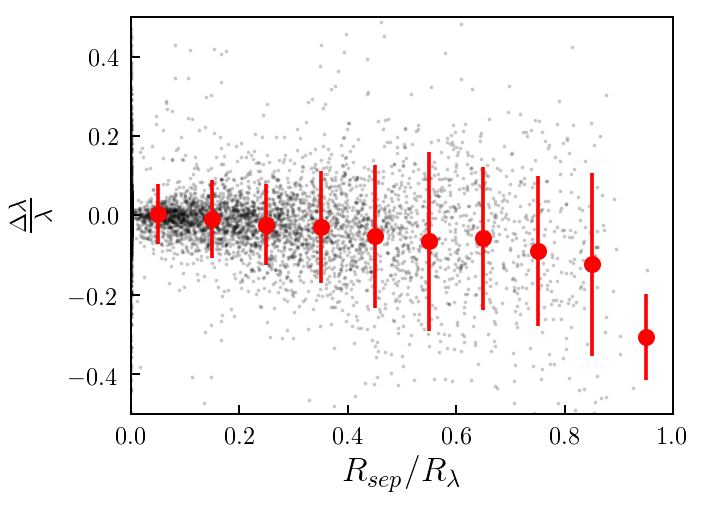

In [302]:
from scipy.stats import binned_statistic as bin_stat
delta_lambdafrac = np.float64(redM_shape.LAMBDA_CHISQ- hrun_data.LAMBDA_CHISQ)/redM_shape.LAMBDA_CHISQ

nbins = 10
dlmdafrac_range = (-0.5,0.5)

#error for deltalambda vs miscentering distance
d_range = (0,1)
n, _ = np.histogram(r_ratio, bins=nbins, range=d_range)
sy, d_bins = np.histogram(r_ratio, bins=nbins, weights=delta_lambdafrac, range=d_range)
sy2, d_bins = np.histogram(r_ratio, bins=nbins, weights=delta_lambdafrac**2., range=d_range)
lmda_d_mean = sy / n
lmda_d_std = np.sqrt(sy2/n - lmda_d_mean**2.)

fig, ax = plt.subplots(1,1, figsize = (4,3))
#plt.tight_layout()
#Scatter plots
ax.scatter(r_ratio, delta_lambdafrac, s=0.3, alpha=0.2, color='black')
ax.errorbar((d_bins[1:] + d_bins[:-1])/2, lmda_d_mean, yerr=lmda_d_std, fmt='ro')
ax.set_xlim(d_range)
ax.set_ylim(dlmdafrac_range)

ax.set_ylabel(r'$\frac{\Delta\lambda}{\lambda}$', fontsize=14)
ax.set_xlabel(r'$R_{sep}/R_{\lambda}$', fontsize=14)

plt.show()

### Scatter

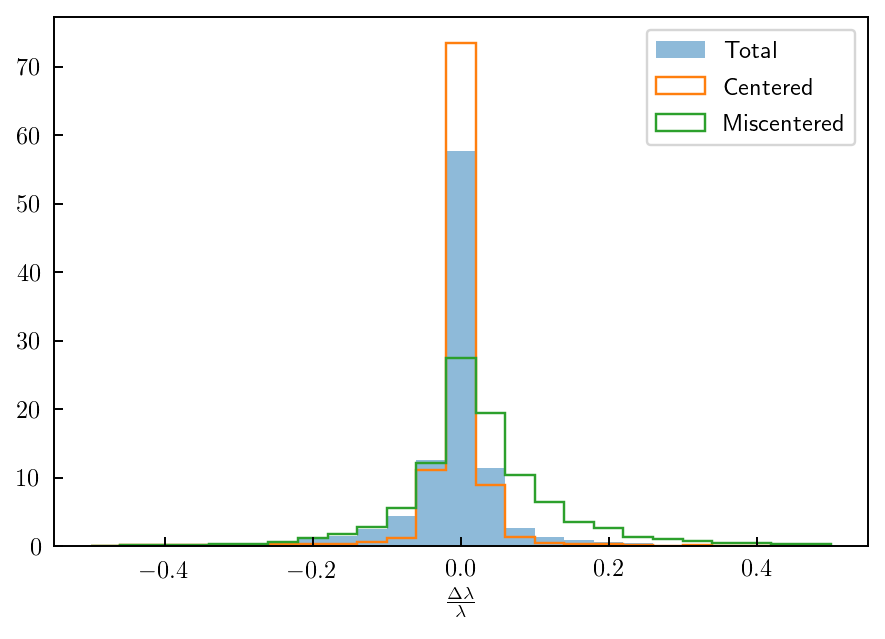

In [253]:
#Make this into absolute fraction
weights_tot = np.ones_like(redM_shape.LAMBDA_CHISQ, dtype=float)/len(redM_shape)* 100
weights_cent = np.ones_like(redM_shape_cent.LAMBDA_CHISQ, dtype=float)/len(redM_shape_cent)* 100
weights_miscent = np.ones_like(redM_shape_miscent.LAMBDA_CHISQ, dtype=float)/len(redM_shape_miscent)* 100

nbins = 25
plt.hist(delta_lambdafrac, nbins, range=(-0.5,0.5), alpha=0.5, weights=weights_tot, fill=True, label='Total')
plt.hist(delta_lambdafrac_cent, nbins, range=(-0.5,0.5), weights=weights_cent, fill=False, histtype='step', label='Centered')
plt.hist(delta_lambdafrac_miscent, nbins, range=(-0.5,0.5), weights=weights_miscent, fill=False, histtype='step', label='Miscentered')
plt.xlabel(r'$\frac{\Delta\lambda}{\lambda}$')
plt.legend()
plt.show()

## Correlation with cos(i)

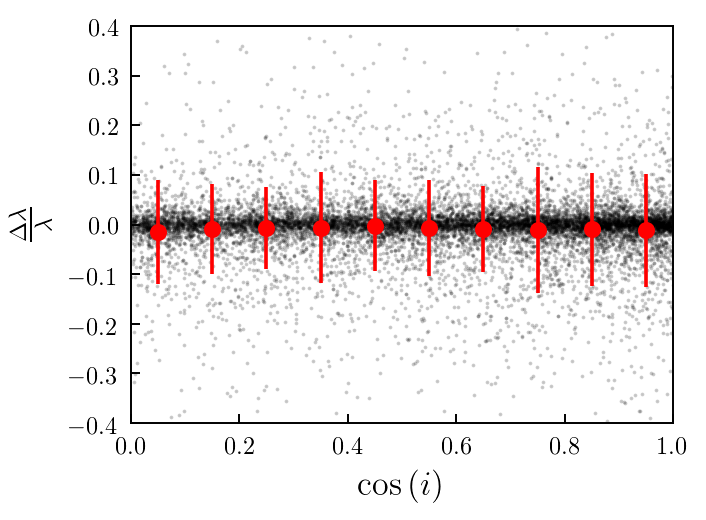

In [271]:
from scipy.stats import binned_statistic as bin_stat
delta_lambdafrac = np.float64(redM_shape.LAMBDA_CHISQ- hrun_data.LAMBDA_CHISQ )/redM_shape.LAMBDA_CHISQ

nbins = 10
dlmdafrac_range = (-0.4,0.4)
#error for mass
cosi_range = (0.0,1)
n, _ = np.histogram(redM_shape.cosi, bins=nbins, range=cosi_range)
sy, _ = np.histogram(redM_shape.cosi, bins=nbins, weights=delta_lambdafrac, range=cosi_range)
sy2, cosi_bins = np.histogram(redM_shape.cosi, bins=nbins, weights=delta_lambdafrac**2., range=cosi_range)
lmda_cosi_mean = sy / n
lmda_cosi_std = np.sqrt(sy2/n - lmda_cosi_mean**2.)


fig, ax = plt.subplots(1,1, figsize = (4,3))
#plt.tight_layout()
#Scatter plots
ax.scatter(redM_shape.cosi, delta_lambdafrac, s=0.3, alpha=0.2, color='black')
ax.errorbar((cosi_bins[1:] + cosi_bins[:-1])/2, lmda_cosi_mean, yerr=lmda_cosi_std, fmt='ro')
ax.set_xlim(cosi_range)
ax.set_ylim(dlmdafrac_range)

ax.set_ylabel(r'$\frac{\Delta\lambda}{\lambda}$', fontsize=14)
ax.set_xlabel(r'$\cos{(i)}$', fontsize=14)

#Error plots
#For mass of hrun
#dLmda_mass_mean = bin_stat(hrun_data_halocut.M200, delta_lambda, bins=num_bin, range=(5e13,5e14))[0]
#dLmda_mass_stdev = bin_stat(hrun_data_halocut.M200, delta_lambda, bins=num_bin, range=(5e13,5e14))[0]

plt.show()

## Test

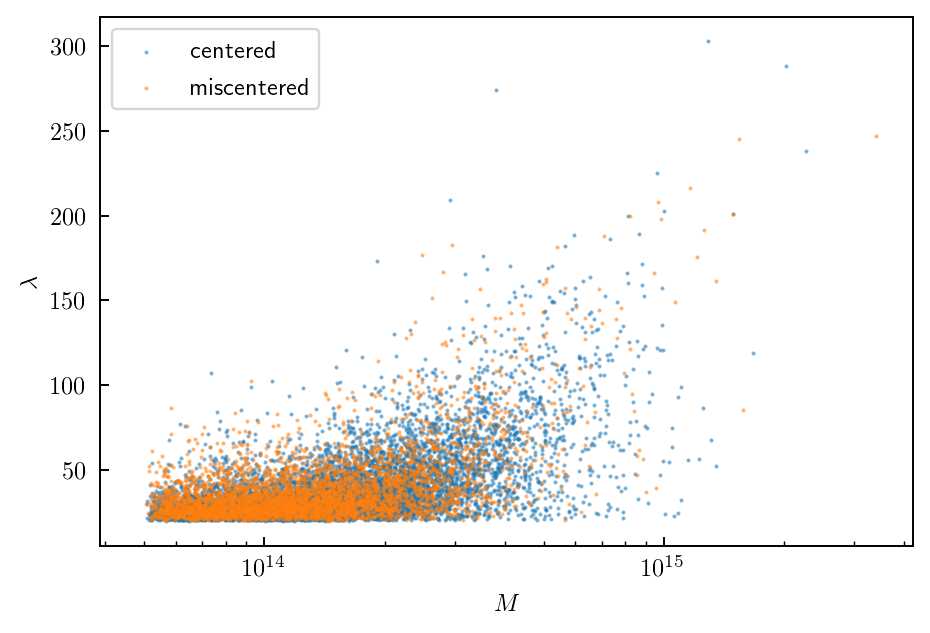

11172
2.904122276855492


In [170]:
delta_lambdafrac = np.float64(hrun_data.LAMBDA_CHISQ - redM_shape.LAMBDA_CHISQ)/redM_shape.LAMBDA_CHISQ
delta_lambdafrac_cent = np.float64(hrun_cent.LAMBDA_CHISQ - redM_shape_cent.LAMBDA_CHISQ)/redM_shape_cent.LAMBDA_CHISQ
delta_lambdafrac_miscent = np.float64(hrun_miscent.LAMBDA_CHISQ - redM_shape_miscent.LAMBDA_CHISQ)/redM_shape_miscent.LAMBDA_CHISQ
plt.scatter(redM_shape_cent.M200B, redM_shape_cent.LAMBDA_CHISQ, alpha=0.5, s=0.5, label='centered')
plt.scatter(redM_shape_miscent.M200B, redM_shape_miscent.LAMBDA_CHISQ, alpha=0.5, s=0.5, label = 'miscentered')
plt.legend()
plt.ylabel(r'$\lambda$')
plt.xlabel(r'$M$')
plt.xscale('log')
plt.show()
print len(np.where(delta_lambdafrac < 0.1)[0])
print max(delta_lambdafrac)

## Testing lambda ratios with Radius and miscentering

In [172]:
print redM_data.dtype
print redM_data[0].LAMBDA_CHISQ_CENT
print redM_data[0].NCENT
print redM_data[0].NCENT_GOOD
print redM_data[0].P_CEN
print redM_data[0].P_BCG
print redM_data[0].LAMBDA_CHISQ
print redM_data[0].LAMBDA_CHISQ_CENT[1]/redM_data[0].LAMBDA_CHISQ_CENT[0]

(numpy.record, [('MEM_MATCH_ID', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('MODEL_MAG', '>f4', (4,)), ('MODEL_MAGERR', '>f4', (4,)), ('REFMAG', '>f4'), ('REFMAG_ERR', '>f4'), ('ZRED', '>f4'), ('ZRED_E', '>f4'), ('ZRED_CHISQ', '>f4'), ('BCG_SPEC_Z', '>f4'), ('Z_SPEC_INIT', '>f4'), ('Z_INIT', '>f4'), ('Z', '>f4'), ('LAMBDA_CHISQ', '>f4'), ('LAMBDA_CHISQ_E', '>f4'), ('LAMBDA_ZRED', '>f4'), ('LAMBDA_ZRED_E', '>f4'), ('R_LAMBDA', '>f4'), ('SCALEVAL', '>f4'), ('MASKFRAC', '>f4'), ('GEOMASKFRAC', '>f4'), ('C_LAMBDA', '>f4', (3,)), ('C_LAMBDA_ERR', '>f4', (3,)), ('MAG_LAMBDA_ERR', '>f4', (4,)), ('CHISQ', '>f4'), ('Z_LAMBDA', '>f4'), ('Z_LAMBDA_E', '>f4'), ('Z_LAMBDA_NITER', '>i2'), ('EBV_MEAN', '>f4'), ('LNLAMLIKE', '>f4'), ('LNBCGLIKE', '>f4'), ('LNLIKE', '>f4'), ('PZBINS', '>f4', (21,)), ('PZ', '>f4', (21,)), ('NCROSS', '>i2'), ('RMASK', '>f4'), ('RA_ORIG', '>f8'), ('DEC_ORIG', '>f8'), ('W', '>f4'), ('DLAMBDA_DZ', '>f4'), ('DLAMBDA_DZ2', '>f4'), ('DLAMBDAVAR_DZ', '>f4'), ('DLAMBDAVAR_DZ2', '>f